In [1]:
from utils.data import Dataset
from utils.conllu import read_conllu_dataset
import numpy as np

In [2]:
dataset = Dataset()

train_sentences = read_conllu_dataset("data/ro_rrt-ud-train.conllu")
test_sentences = read_conllu_dataset("data/ro_rrt-ud-test.conllu")

# Fit on training data
X_train, y_train = dataset.fit(train_sentences, mode="word_id", categorical_y=False)

# Encode test data (fixed shape)
X_test, y_test = dataset.encode(test_sentences)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8043, 163), (8043, 163), (729, 163), (729, 163))

In [3]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('int64'))

In [4]:
def np2unohomegeneouslist(X,y):
    l_X, l_y = [], []
    for i in range(len(X)):
        zeros = np.argwhere(X[i]==0)
        seq_len = zeros[0,0] if len(zeros)>0 else len(X[i])
        l_X.append(X[i][0:seq_len])
        l_y.append(y[i][0:seq_len])    
    return l_X, l_y

X, y = np2unohomegeneouslist(X_train.astype('int'), y_train)

Classification Report:
              precision    recall  f1-score   support

         ADJ       0.42      0.53      0.47      1172
         ADP       0.62      0.85      0.72      2333
         ADV       0.45      0.21      0.29       650
         AUX       0.28      0.16      0.21       618
       CCONJ       0.90      0.75      0.82       471
         DET       0.24      0.15      0.19       898
        INTJ       0.00      0.00      0.00         6
        NOUN       0.59      0.72      0.65      4042
         NUM       0.30      0.13      0.19       456
        PART       0.64      0.47      0.54       358
        PRON       0.34      0.28      0.31       862
       PROPN       0.59      0.07      0.12       455
       PUNCT       0.79      0.95      0.86      2083
       SCONJ       0.60      0.20      0.30       154
        VERB       0.59      0.42      0.49      1749
           X       0.00      0.00      0.00        17

    accuracy                           0.58     16324
   

d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

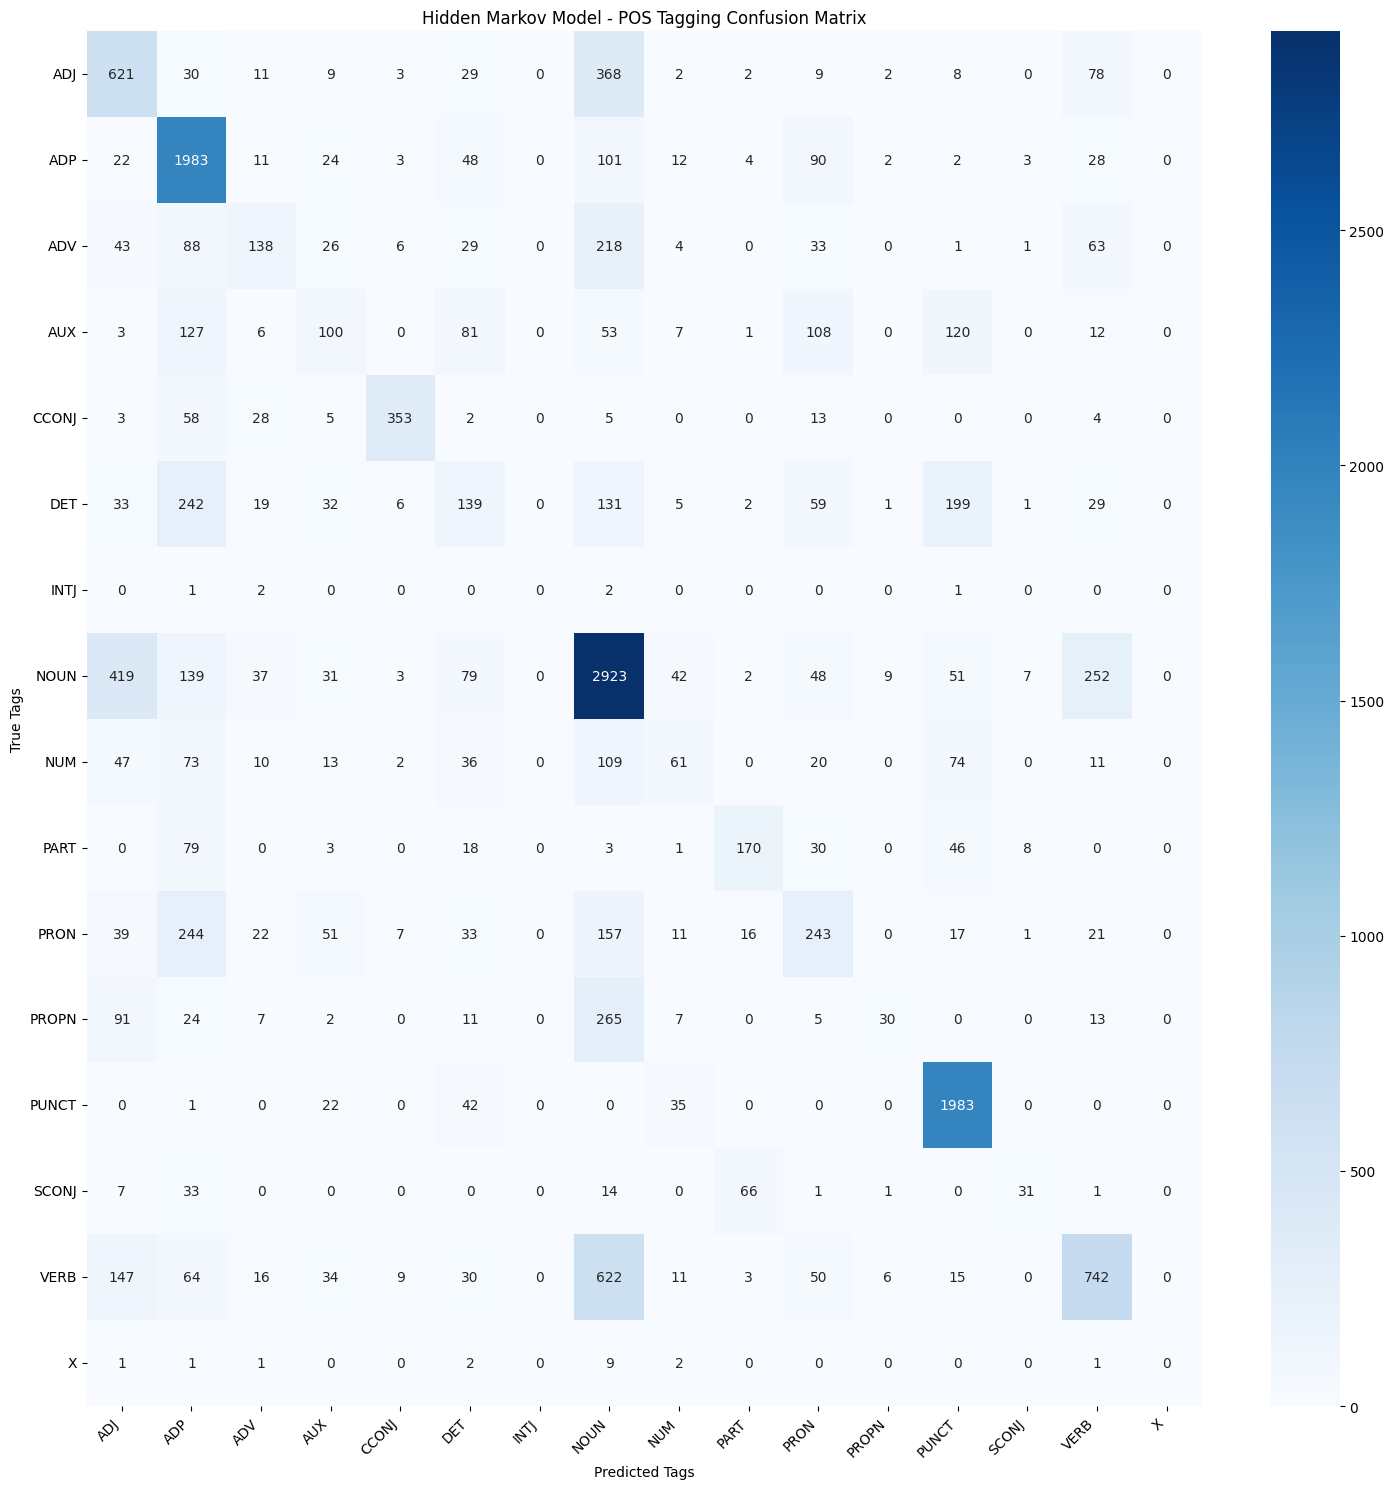


Test Accuracy: 0.5830


In [5]:
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the number of unique tags and words
n_tags = len(dataset.label2id)
n_words = len(dataset.word2id)

# Convert sequences to format suitable for hmmlearn
def prepare_sequences(X, y):
    # Convert lists to numpy arrays first
    lengths = [len(seq) for seq in X]
    # Ensure the sequences are integer type
    X_flat = np.concatenate([np.array(seq, dtype=np.int32).reshape(-1, 1) for seq in X])
    y_flat = np.concatenate([np.array(seq, dtype=np.int32) for seq in y])
    return X_flat, y_flat, lengths

# Initialize HMM
model = hmm.CategoricalHMM(n_components=n_tags, n_iter=1000, init_params='')

# Initialize emission probabilities from labeled data
emission_counts = np.zeros((n_tags, n_words))
for x_seq, y_seq in zip(X, y):
    for word, tag in zip(x_seq, y_seq):
        emission_counts[int(tag), int(word)] += 1

# Add-1 smoothing and normalize emissions
model.emissionprob_ = (emission_counts + 1) / (emission_counts.sum(axis=1, keepdims=True) + n_words)

# Initialize transition probabilities from labeled data
transition_counts = np.zeros((n_tags, n_tags))
for y_seq in y:
    for i in range(len(y_seq) - 1):
        transition_counts[int(y_seq[i]), int(y_seq[i+1])] += 1

# Add-1 smoothing and normalize transitions
model.transmat_ = (transition_counts + 1) / (transition_counts.sum(axis=1, keepdims=True) + n_tags)

# Initialize start probabilities from labeled data
start_counts = np.zeros(n_tags)
for y_seq in y:
    start_counts[int(y_seq[0])] += 1
# Add-1 smoothing and normalize start probabilities
model.startprob_ = (start_counts + 1) / (start_counts.sum() + n_tags)

# Prepare test data
X_test_list, y_test_list = np2unohomegeneouslist(X_test, y_test)
X_test_flat, y_test_flat, test_lengths = prepare_sequences(X_test_list, y_test_list)

# Predict on test data using Viterbi algorithm
predicted_tags = model.decode(X_test_flat, test_lengths)[1]

# Get unique labels that actually appear in the data
unique_labels = np.unique(np.concatenate([y_test_flat, predicted_tags]))
label_names = [list(dataset.label2id.keys())[i] for i in unique_labels]

# Calculate and print metrics
print("Classification Report:")
print(classification_report(y_test_flat, predicted_tags,
                          labels=unique_labels,
                          target_names=label_names))

# Create confusion matrix visualization
cm = confusion_matrix(y_test_flat, predicted_tags,
                      labels=unique_labels)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title('Hidden Markov Model - POS Tagging Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print overall accuracy
accuracy = np.mean(y_test_flat == predicted_tags)
print(f"\nTest Accuracy: {accuracy:.4f}")

In [6]:
import os
import joblib

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the trained HMM model
model_path = os.path.join('models', 'pos_hmm_model.joblib')
joblib.dump(model, model_path)

# Also save the label mapping for future use
mapping_path = os.path.join('models', 'pos_hmm_mappings.joblib')
label_mapping = {
    'label2id': dataset.label2id,
    'id2label': {v: k for k, v in dataset.label2id.items()},
    'word2id': dataset.word2id,
    'id2word': {v: k for k, v in dataset.word2id.items()}
}
joblib.dump(label_mapping, mapping_path)

print(f"Model saved to: {model_path}")
print(f"Mappings saved to: {mapping_path}")

Model saved to: models\pos_hmm_model.joblib
Mappings saved to: models\pos_hmm_mappings.joblib


In [7]:
#model = joblib.load('pos_hmm_model.joblib')
#mappings = joblib.load('pos_hmm_mappings.joblib')